In [1]:
from __future__ import print_function
import os, sys
sys.path.insert(0, os.environ['PROJECT_PATH'])

In [2]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

sns.set()
%matplotlib inline

In [7]:
path_to_locs = os.path.join(os.environ['DATA_PATH'], 'interim', 'sample_meetup_locations.csv')
sample_loc_df = pd.read_csv(path_to_locs, encoding='latin1')

In [8]:
path_to_sample_events = os.path.join(os.environ['DATA_PATH'], 'raw', 'topics', 'sample_events.csv')

In [9]:
sample_events_df = pd.read_csv(path_to_sample_events, encoding='latin1')

In [18]:
print(sample_events_df.shape, sample_loc_df.shape)

(9754, 6) (65, 8)


In [19]:
extra_columns = [ 'City', 'Country', 'ZipCode', 'State', 'Latitude', 'Longitude' ]
master_df = pd.merge(sample_events_df, sample_loc_df, left_on=['latitude', 'longitude'], 
                     right_on=['Latitude', 'Longitude'], how='inner').drop(extra_columns, axis=1)
# print(sample_events_df.shape, master_df.shape)
master_df.head()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,MSA_NAME,MSA_CODE
0,pfzblmywqbnb,1513566000000,25.0,6,39.96,-105.49,"Boulder, CO Metro Area",14500.0
1,tjlzznywqbxb,1513605600000,9.0,5,39.96,-105.49,"Boulder, CO Metro Area",14500.0
2,243691042,1513609200000,34.0,4,39.96,-105.49,"Boulder, CO Metro Area",14500.0
3,nwhhmnywqbxb,1513609200000,9.0,3,39.96,-105.49,"Boulder, CO Metro Area",14500.0
4,qxbzwnywqbxb,1513611000000,23.0,8,39.96,-105.49,"Boulder, CO Metro Area",14500.0


## Exploring the time events took place

In [20]:
master_df['formatted_time'] = pd.to_datetime(master_df['time'], unit='ms')
master_df.head()

,id,time,group.category.id,yes_rsvp_count,latitude,longitude,MSA_NAME,MSA_CODE,formatted_time
0,pfzblmywqbnb,1513566000000,25.0,6,39.96,-105.49,"Boulder, CO Metro Area",14500.0,2017-12-18 03:00:00
1,tjlzznywqbxb,1513605600000,9.0,5,39.96,-105.49,"Boulder, CO Metro Area",14500.0,2017-12-18 14:00:00
2,243691042,1513609200000,34.0,4,39.96,-105.49,"Boulder, CO Metro Area",14500.0,2017-12-18 15:00:00
3,nwhhmnywqbxb,1513609200000,9.0,3,39.96,-105.49,"Boulder, CO Metro Area",14500.0,2017-12-18 15:00:00
4,qxbzwnywqbxb,1513611000000,23.0,8,39.96,-105.49,"Boulder, CO Metro Area",14500.0,2017-12-18 15:30:00


In [21]:
from datetime import datetime
from datetime import timedelta

curr_date = datetime.now().date()

start_of_curr_month = curr_date.replace(day=1)
three_months_from_now = start_of_curr_month + timedelta(days=3*32)
three_months_from_now = three_months_from_now.replace(day=curr_date.day)

# restricting to events taking place three months from now
master_df = master_df[ master_df['formatted_time'] <= three_months_from_now]

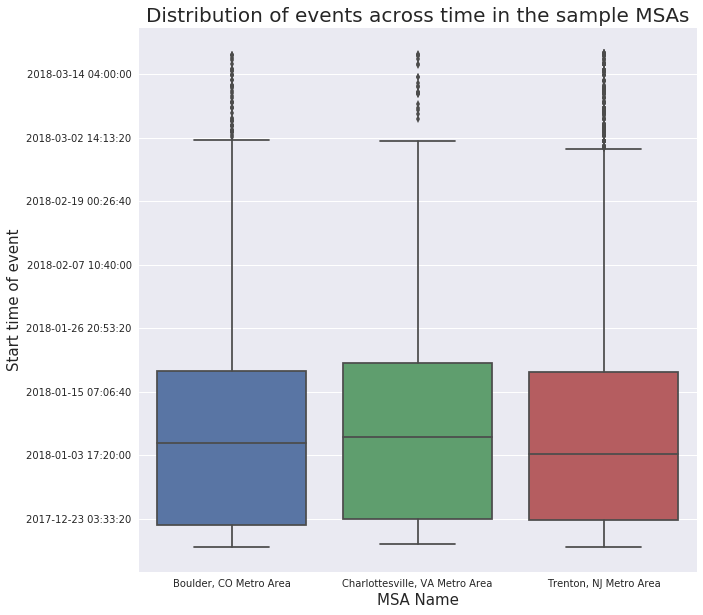

In [22]:
plt.subplots(figsize=(10, 10))
ax = sns.boxplot(x='MSA_NAME', y='time', data=master_df)

yticks = ax.get_yticks()
ax.set_yticklabels([pd.to_datetime(tm, unit='ms') for tm in yticks])
ax.axes.set_title("Distribution of events across time in the sample MSAs",fontsize=20)
ax.set_xlabel("MSA Name",fontsize=15)
ax.set_ylabel("Start time of event",fontsize=15)

print()

## Exploring the number of events across the sample MSAs 

In [26]:
master_df.groupby([ 'MSA_CODE', 'MSA_NAME' ]).count()

,,id,time,group.category.id,yes_rsvp_count,latitude,longitude,formatted_time
MSA_CODE,MSA_NAME,,,,,,,
14500.0,"Boulder, CO Metro Area",2335,2335,2335,2335,2335,2335,2335
16820.0,"Charlottesville, VA Metro Area",544,544,544,544,544,544,544
45940.0,"Trenton, NJ Metro Area",5680,5680,5679,5680,5680,5680,5680


## Exploring the popularity of events in each category across the sample MSAs 

### By raw event count 

In [27]:
import requests

url_template = "https://api.meetup.com/2/categories?&sign=true&photo-host=public&page=40&key={api_key}"

res = requests.get(url_template.format(api_key=os.environ['API_KEY']))

payload = res.json()

category_ids = { item['id']: item['name'] for item in payload['results'] }

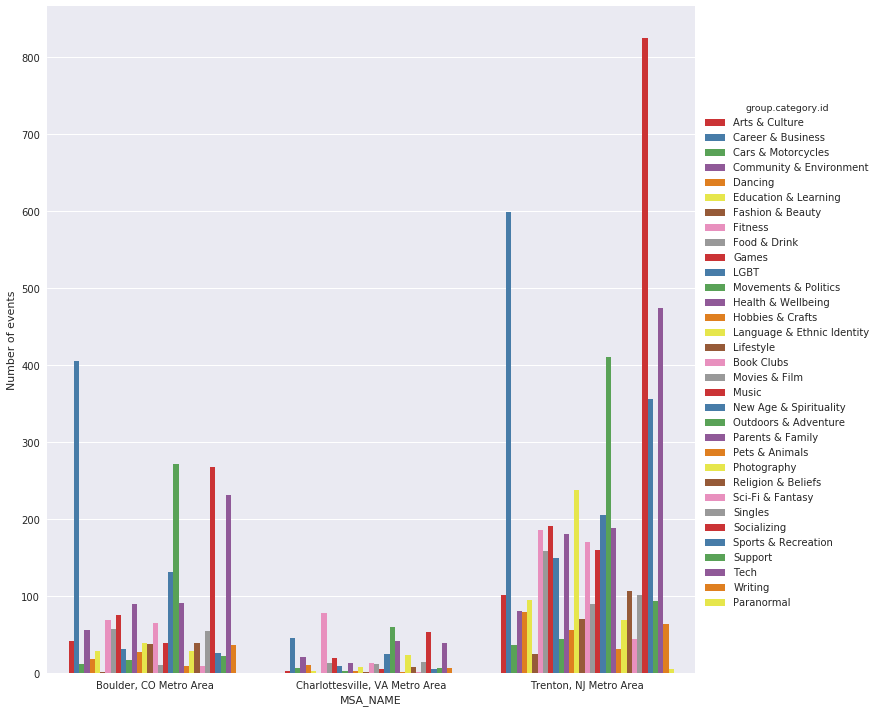

In [31]:
events_count = master_df.groupby(['MSA_CODE', 'MSA_NAME', 'group.category.id']).count().reset_index()

events_count['group.category.id'] = events_count['group.category.id'].apply(lambda x: category_ids[x])

g = sns.factorplot(x='MSA_NAME', y='id', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_count)
g.set_ylabels('Number of events')
print()

### Top 5 Categories

In [32]:
trenton_top5 = events_count[ events_count['MSA_CODE'] == 45940].sort_values('id', ascending=False).head()
cville_top5 = events_count[ events_count['MSA_CODE'] == 16820].sort_values('id', ascending=False).head()
boulder_top5 = events_count[ events_count['MSA_CODE'] == 14500].sort_values('id', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
        group.category.id  yes_rsvp_count
91           Socializing             825
64     Career & Business             599
94                  Tech             474
83  Outdoors & Adventure             410
92   Sports & Recreation             356

Cville Top 5:
        group.category.id  yes_rsvp_count
38               Fitness              78
51  Outdoors & Adventure              59
58           Socializing              53
33     Career & Business              45
52      Parents & Family              41

Boulder Top 5:
          group.category.id  yes_rsvp_count
1        Career & Business             406
20    Outdoors & Adventure             272
27             Socializing             267
30                    Tech             231
19  New Age & Spirituality             131


### By attendance per million people in each city 

In [34]:
path_to_msa_populations = os.path.join(os.environ['DATA_PATH'], 'external', 'msa_population.xlsx')
msa_pop_df = pd.read_excel(path_to_msa_populations)

augmented_df = pd.merge(master_df, msa_pop_df[ ['cbsa15', 'pop_acs16'] ], how='inner', 
                        left_on='MSA_CODE', right_on='cbsa15').drop('cbsa15', axis=1)

# add up the populations of msa in each city to serve as the city's population
# pop_by_city = augmented_df.groupby('City').sum().reset_index()

# augmented_df.drop('pop_acs16', axis=1, inplace=True)
# augmented_df = pd.merge(augmented_df, pop_by_city[ ['City', 'pop_acs16'] ], how='inner', on='City')

# normalize the event attendance by the city's population
augmented_df['attendance_norm'] = ( augmented_df['yes_rsvp_count'] / augmented_df['pop_acs16'] )

events_attendance = augmented_df.groupby( ['MSA_CODE', 'MSA_NAME', 'group.category.id' ] ).sum().reset_index()

events_attendance['group.category.id'] = events_attendance['group.category.id'].apply(lambda x: category_ids[x])

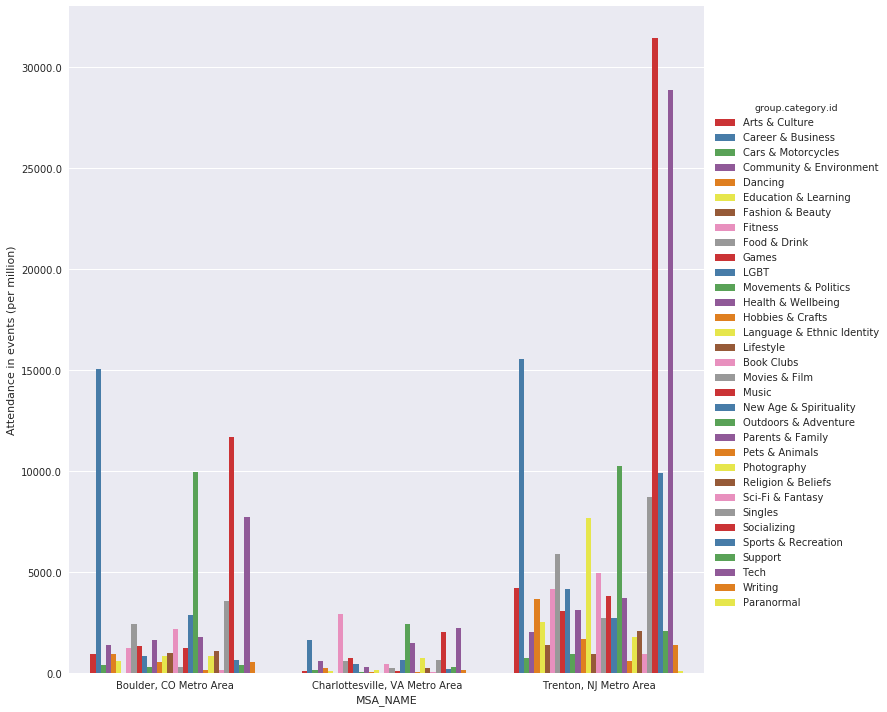

In [35]:
g = sns.factorplot(x='MSA_NAME', y='attendance_norm', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_attendance)
g.set_ylabels('Attendance in events (per million)')
ax = g.axes.flatten()[0]
ax.set_yticklabels([ tick * 1000000 for tick in ax.get_yticks()])
print() 

In [37]:
trenton_top5 = events_attendance[ events_attendance['MSA_CODE'] == 45940].sort_values('attendance_norm', ascending=False).head()
cville_top5 = events_attendance[ events_attendance['MSA_CODE'] == 16820].sort_values('attendance_norm', ascending=False).head()
boulder_top5 = events_attendance[ events_attendance['MSA_CODE'] == 14500].sort_values('attendance_norm', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
        group.category.id  yes_rsvp_count
91           Socializing           11670
94                  Tech           10712
64     Career & Business            5766
83  Outdoors & Adventure            3798
92   Sports & Recreation            3679

Cville Top 5:
        group.category.id  yes_rsvp_count
38               Fitness             670
51  Outdoors & Adventure             551
61                  Tech             512
58           Socializing             466
33     Career & Business             369

Boulder Top 5:
        group.category.id  yes_rsvp_count
1      Career & Business            4855
27           Socializing            3763
20  Outdoors & Adventure            3207
30                  Tech            2485
26               Singles            1151


### By attendance per million people and per event in each city

In [42]:
# redo the events count due to some invalid rows being dropped (some MSAs did not have a pop. count)
events_count = augmented_df.groupby( ['MSA_CODE', 'MSA_NAME', 'group.category.id'] ).count().reset_index()

# normalize the attendance further by the number of events in each city and each category
events_attendance['attendance_norm'] = events_attendance['attendance_norm'] / events_count['id']

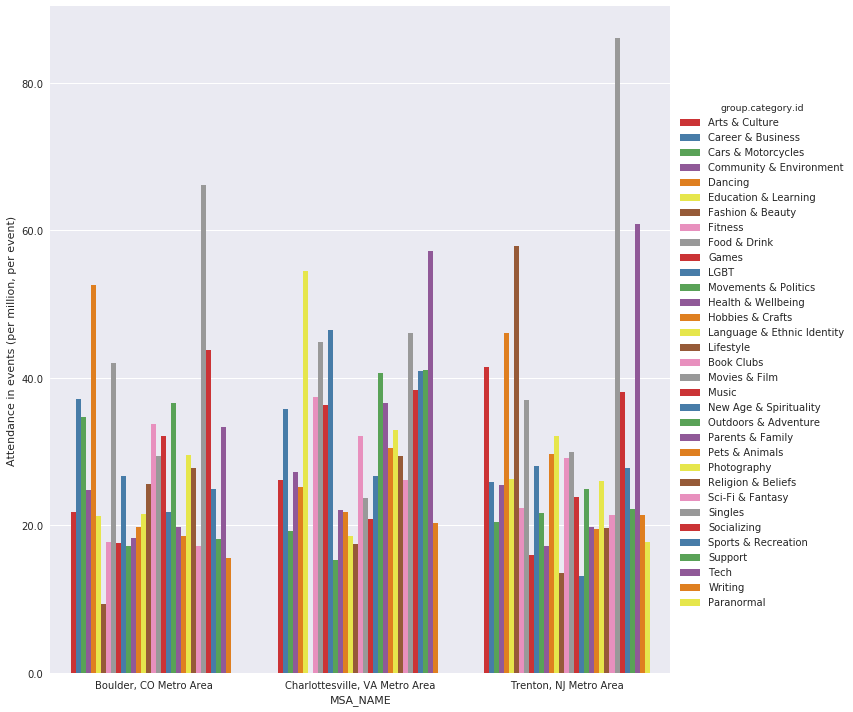

In [43]:
g = sns.factorplot(x='MSA_NAME', y='attendance_norm', hue='group.category.id', palette=sns.color_palette('Set1', 100), 
                   size=10, kind='bar', data=events_attendance)
g.set_ylabels('Attendance in events (per million, per event)')
ax = g.axes.flatten()[0]
ax.set_yticklabels( [ tick * 1000000 for tick in ax.get_yticks()] )
print()

In [44]:
trenton_top5 = events_attendance[ events_attendance['MSA_CODE'] == 45940].sort_values('attendance_norm', ascending=False).head()
cville_top5 = events_attendance[ events_attendance['MSA_CODE'] == 16820].sort_values('attendance_norm', ascending=False).head()
boulder_top5 = events_attendance[ events_attendance['MSA_CODE'] == 14500].sort_values('attendance_norm', ascending=False).head()

print('\nTrenton Top 5:\n', trenton_top5[ ['group.category.id', 'yes_rsvp_count'] ]) 
print('\nCville Top 5:\n', cville_top5[ ['group.category.id', 'yes_rsvp_count'] ])
print('\nBoulder Top 5:\n', boulder_top5[ ['group.category.id', 'yes_rsvp_count'] ])


Trenton Top 5:
    group.category.id  yes_rsvp_count
90           Singles            3226
94              Tech           10712
69  Fashion & Beauty             515
67           Dancing            1353
63    Arts & Culture            1557

Cville Top 5:
        group.category.id  yes_rsvp_count
61                  Tech             512
37  Education & Learning              25
41                  LGBT              96
57               Singles             148
39          Food & Drink             134

Boulder Top 5:
     group.category.id  yes_rsvp_count
26            Singles            1151
4             Dancing             305
27        Socializing            3763
8        Food & Drink             773
1   Career & Business            4855
